<a href="https://colab.research.google.com/github/santiagoahl/beans-classification/blob/main/beans_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Data Pre-Processing for vision](#scrollTo=Tb36zMnYC_ti)

>>[Loading the ViT Feature Extractor](#scrollTo=TLjAtzl1EyX7)

>[Data processing](#scrollTo=2oLwAiZfIc_v)

>>[Data collator](#scrollTo=2NEl15IIKbEM)

>[Training](#scrollTo=2PjwBxXvLl__)

>>[Metrics](#scrollTo=9v3fm53yLqyU)

>>[Trainer](#scrollTo=SSjLVVlnMTqM)

>>[Trainer arguments](#scrollTo=1UpOPCuaN5SR)

>>[Train computer vision model](#scrollTo=gQAjzBI6l51I)

>[Testing](#scrollTo=pjOFc3DOnb8s)



# Data Pre-Processing for vision

In [1]:
%%capture
!pip install datasets transformers

In [2]:
from datasets import load_dataset

data = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [4]:
example = data['train'][400]
example

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/healthy/healthy_train.319.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F0189056B90>,
 'labels': 2}

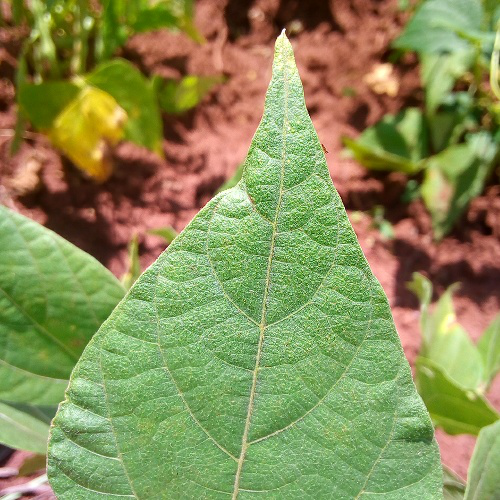

In [5]:
image = example['image']
image

Labels

In [6]:
labels = data['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [7]:
labels.int2str(example['labels'])

'healthy'

## Loading the ViT Feature Extractor

`ViT Feature Extractor` Let us find the correct image transformation for our pre-trained model

In [8]:
from transformers.models.vit.feature_extraction_vit import ViTFeatureExtractor
from transformers import ViltFeatureExtractor

repo_id = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

See the FE

In [9]:
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



Process just an image:

In [10]:
feature_extractor(image, return_tensors="pt") 

{'pixel_values': tensor([[[[ 0.1451,  0.3725,  0.4588,  ..., -0.2784, -0.2784, -0.2627],
          [ 0.1608,  0.3961,  0.4588,  ..., -0.2941, -0.2863, -0.2784],
          [ 0.1765,  0.4275,  0.5137,  ..., -0.3176, -0.2706, -0.1843],
          ...,
          [ 0.2941,  0.3176,  0.4824,  ..., -0.1216, -0.1373, -0.1137],
          [ 0.1843,  0.3490,  0.5608,  ..., -0.1059, -0.1529, -0.1373],
          [ 0.4980,  0.6314,  0.7961,  ..., -0.1294, -0.1686, -0.1765]],

         [[-0.1059,  0.0745,  0.1529,  ..., -0.0510, -0.0431, -0.0275],
          [-0.1294,  0.0275,  0.0745,  ..., -0.0667, -0.0431, -0.0275],
          [-0.1373,  0.0196,  0.0431,  ..., -0.0745, -0.0039,  0.0824],
          ...,
          [-0.0196,  0.0667,  0.3098,  ...,  0.0353,  0.0039,  0.0275],
          [ 0.0431,  0.2941,  0.5765,  ...,  0.0588, -0.0275, -0.0196],
          [ 0.4824,  0.6941,  0.8902,  ...,  0.0353, -0.0431, -0.0588]],

         [[-0.4824, -0.3333, -0.3490,  ..., -0.7176, -0.7725, -0.8039],
          [-0

In [11]:
feature_extractor(image, return_tensors="pt").keys()

dict_keys(['pixel_values'])

In [12]:
# Pixel tensor shape per image
feature_extractor(image, return_tensors="pt")['pixel_values'].shape

torch.Size([1, 3, 224, 224])

# Data processing

In [13]:
def process_example(example):
  inputs = feature_extractor(example['image'], return_tensors='pt')
  inputs['labels'] = example['labels']
  return inputs

In [14]:
process_example(data['train'][0])

{'pixel_values': tensor([[[[-0.7647, -0.7569, -0.7333,  ...,  0.3569,  0.3647,  0.3020],
          [-0.7412, -0.7412, -0.7333,  ...,  0.3255,  0.3098,  0.2549],
          [-0.7255, -0.7176, -0.7255,  ...,  0.3255,  0.2627,  0.2863],
          ...,
          [-0.4431, -0.4353, -0.4039,  ..., -0.5529, -0.5451, -0.7176],
          [-0.3725, -0.3882, -0.3725,  ..., -0.5686, -0.6000, -0.7490],
          [-0.2863, -0.3647, -0.3333,  ..., -0.5843, -0.7176, -0.7647]],

         [[-0.5529, -0.5608, -0.5608,  ..., -0.1765, -0.1608, -0.2157],
          [-0.5529, -0.5451, -0.5451,  ..., -0.2078, -0.2157, -0.2784],
          [-0.5373, -0.5216, -0.5294,  ..., -0.2235, -0.2706, -0.2471],
          ...,
          [-0.7647, -0.7569, -0.7333,  ..., -0.3255, -0.3490, -0.5216],
          [-0.7176, -0.7333, -0.7255,  ..., -0.3412, -0.3961, -0.5373],
          [-0.6392, -0.7255, -0.6941,  ..., -0.3569, -0.5059, -0.5608]],

         [[-1.0000, -0.9843, -0.9686,  ..., -0.1843, -0.1451, -0.2000],
          [-0

Now map by batches as in the previous example with `map`

In [15]:
def transform(example_batch):
  inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
  inputs['labels'] = example_batch['labels']
  return inputs

In [16]:
prepared_data = data.with_transform(transform)

In [17]:
prepared_data['train'][0:2]

{'pixel_values': tensor([[[[-0.7647, -0.7569, -0.7333,  ...,  0.3569,  0.3647,  0.3020],
          [-0.7412, -0.7412, -0.7333,  ...,  0.3255,  0.3098,  0.2549],
          [-0.7255, -0.7176, -0.7255,  ...,  0.3255,  0.2627,  0.2863],
          ...,
          [-0.4431, -0.4353, -0.4039,  ..., -0.5529, -0.5451, -0.7176],
          [-0.3725, -0.3882, -0.3725,  ..., -0.5686, -0.6000, -0.7490],
          [-0.2863, -0.3647, -0.3333,  ..., -0.5843, -0.7176, -0.7647]],

         [[-0.5529, -0.5608, -0.5608,  ..., -0.1765, -0.1608, -0.2157],
          [-0.5529, -0.5451, -0.5451,  ..., -0.2078, -0.2157, -0.2784],
          [-0.5373, -0.5216, -0.5294,  ..., -0.2235, -0.2706, -0.2471],
          ...,
          [-0.7647, -0.7569, -0.7333,  ..., -0.3255, -0.3490, -0.5216],
          [-0.7176, -0.7333, -0.7255,  ..., -0.3412, -0.3961, -0.5373],
          [-0.6392, -0.7255, -0.6941,  ..., -0.3569, -0.5059, -0.5608]],

         [[-1.0000, -0.9843, -0.9686,  ..., -0.1843, -0.1451, -0.2000],
          [-0

## Data collator

In [18]:
import torch

In [19]:
def collate_fn(batch):
  """
    Parameters:
      - batch = list: (...) List of images with tensor form 
    Returns: Dictionary with unique key `pixel_values` with a stacked torch tensor that defines the batch
  """
  return {
      "pixel_values": torch.stack([x['pixel_values'] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

# Training

## Metrics

In [20]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


In [21]:
def compute_metrics(prediction):
  return metric.compute(predictions=np.argmax(prediction.predictions, axis=1), references=prediction.label_ids)

## Trainer

In [22]:
# Import hugging face model

from transformers import ViTForImageClassification

labels = data['train'].features['labels'].names

labels

['angular_leaf_spot', 'bean_rust', 'healthy']

In [23]:
model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels=len(labels),
    id2label={str(i):c for i, c in enumerate(labels)},
    label2id={c:str(i) for i,c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Trainer arguments

In [24]:
from transformers import TrainingArguments

In [25]:
training_args = TrainingArguments(
    output_dir="huggingface.co/platzi/vit_model_santiago_ahumada",
    evaluation_strategy='steps',
    num_train_epochs=4,
    learning_rate=2e-4,
    remove_unused_columns=False,
    push_to_hub=True,
    load_best_model_at_end=True
)

In [26]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [27]:
#Training
from transformers import Trainer

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_data['train'],
    eval_dataset=prepared_data['validation'],
    tokenizer=feature_extractor
)

Cloning https://huggingface.co/santiagoahl/vit_model_santiago_ahumada into local empty directory.


## Train computer vision model

In [29]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics('train', train_results.metrics)
trainer.save_metrics('train', train_results.metrics)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 520
  Number of trainable parameters = 85800963


Step,Training Loss,Validation Loss,Accuracy
500,0.143000,0.016394,1.000000


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to huggingface.co/platzi/vit_model_santiago_ahumada/checkpoint-500
Configuration saved in huggingface.co/platzi/vit_model_santiago_ahumada/checkpoint-500/config.json
Model weights saved in huggingface.co/platzi/vit_model_santiago_ahumada/checkpoint-500/pytorch_model.bin
Feature extractor saved in huggingface.co/platzi/vit_model_santiago_ahumada/checkpoint-500/preprocessor_config.json
Feature extractor saved in huggingface.co/platzi/vit_model_santiago_ahumada/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from huggingface.co/platzi/vit_model_santiago_ahumada/checkpoint-500 (score: 0.016393912956118584).
Saving model checkpoint to huggingface.co/platzi/vit_model_santiago_ahumada
Configuration saved in huggingface.co/platzi/vit_model_santiago_ahumada/config.json
Model weights saved in huggingface.co/platzi/vit_model

Upload file pytorch_model.bin:   0%|          | 3.34k/327M [00:00<?, ?B/s]

Upload file runs/Nov08_20-15-46_3a1ebbbcdab1/events.out.tfevents.1667938593.3a1ebbbcdab1.79.0:  73%|#######2  …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/santiagoahl/vit_model_santiago_ahumada
   f8a745a..891220f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/santiagoahl/vit_model_santiago_ahumada
   f8a745a..891220f  main -> main

To https://huggingface.co/santiagoahl/vit_model_santiago_ahumada
   891220f..b2245ff  main -> main

   891220f..b2245ff  main -> main



***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1378
  train_runtime            =  0:03:20.00
  train_samples_per_second =      20.679
  train_steps_per_second   =         2.6


# Testing

In [30]:
metrics = trainer.evaluate(prepared_data['validation'])
trainer.log_metrics('eval', metrics)
trainer.save_metrics('eval', metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0164
  eval_runtime            = 0:00:02.78
  eval_samples_per_second =     47.765
  eval_steps_per_second   =      6.105
